# Notebook to generate all the paper plots

## Import of the necessary libraries

In [1]:
%matplotlib inline
import os
import itertools as it
import cPickle as pkl

from loading_data import loading_data    
from useful_functions import *

from scipy import stats
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

/Users/guignardl/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Loading the data
`loading_data` returns the pre-pocessed informations from the ASTEC outputs.
- `lin_tree` is the lineage tree as a dictionary that maps a cell id at time $t$ to the `list` of its correspondant cell id(s) at time $t+1$. 
```python
lin_tree = {mother_cell_id(int): [daughter_cell_id_1(int), ...], ...}
```
- `inv_lin_tree` is the same as `lin_tree` but links $t+1$ to $t$ and since a cell at $t+1$ as one or less antecedent (in case of the first time point) the dictionary links a cell id to a cell id (not a list).
```python
inv_lin_tree = {daughter_cell_id(int): mother_cell_id(int), ...}
```
- `ColorMap` is a class that allow to create `matplotlib` color maps from lists. (thanks to [Pierre Fernique](https://team.inria.fr/virtualplants/team-members/pfernique/))
- The other outputs are dictionaries that maps a cell id to its associated values:
 - `fates`, `fates2` and `fates3` represent different fate mapping (`fates3` is the one used for this paper).
 - `vol` are the volume of the cells in voxels (computed as the sum of voxels inside the segmented cell).
 - `surfaces` are the suface of the cells. It is computed as the number of outer voxels touching (in a $6-$connected sens) the cell.
 - `names` are the names of the cells as defined by Conklin (after manual correction).
 - `surf_ex` are the cell-cell surface of contacts in voxels as a dictionary of dictionaries:
```python
surf_ex = {cell_id(int): {cell_id(int): area_of_contact(float), ...}, ... }
```
 - `properties` is the dictionary of all the previously described properties plus few others (`properties.keys()` will give the list of available properties)
```python
properties = {property_names(string): [property_dict(dict), default_value(-)], ... }
```

It is worth noticing that the cell id are implemented in a way that it is possible to deduce the time it belongs too and the corresponding label in the image data:
- `cell_id = t*10**4 + label`

hence:
- `label = cell_id%10**4` is the corresonding label in the image
- `t = cell_id//10**4` is the corresponding time (note that // is the floor division)

__SINCE THE AMOUNT OF DATA IS RATHER BIG, THE LOADING TIME MIGHT TAKE SEVERAL MINUTES__

In [2]:
path_to_data = './Data/'
path_to_figures = './Outputs_figures/'

(lin_tree, fates, fates2,
 fates3, vol, inv_lin_tree,
 surf_ex, surfaces, names,
 properties, ColorMap) = loading_data(path_to_data)

`ColorMap` is used to build the main color map for the figures based on the differents fates from `fates3`

In [3]:
## Building the color map
tissue_order = ['Endoderm Head', 'Endodermal Strand 1',
                'Endodermal Strand 2', 'Epidermis Head',
                'Epidermis Tail', 'Germline',
                'Mesoderm Mesenchyme', 'Mesoderm Muscle 1',
                'Mesoderm Muscle 2', 'Mesoderm Notochord 1',
                'Mesoderm Notochord 2',
                'Mesoderm Trunk Lateral Cell',
                'Mesoderm Trunk Ventral Cell',
                'Neural Plate Head Dorsal',
                'Neural Plate Head Ventral',
                'Neural Plate Tail Dorsal',
                'Neural Plate Tail Lateral',
                'Neural Plate Tail Ventral']
CMapFates = ColorMap(tissue_order+['undeter'], 'rainbow')

# ASTEC results analysis

In [5]:
#Creation of the folder where the figures will be outputed
p_to_figures = path_to_figures + 'ASTEC_results_analysis/'
if not os.path.exists(p_to_figures):
    os.makedirs(p_to_figures)

## Plot of the distribution of the $h-min$ values that were used to segment the different cells at different time-points.
The distribution is splited time windows of size `size` to check the evolution of the parametrization of the algorithm

In [6]:
#The h-min informations are contained in the property dictionary
h_min_vals = properties['h_mins_information'][0]
size=40 #size of the window in time points
outputs = []
for t in range(2, 181, size):
    outputs.append([v for k, v in h_min_vals.iteritems() if t<=k//10**4<t+size])

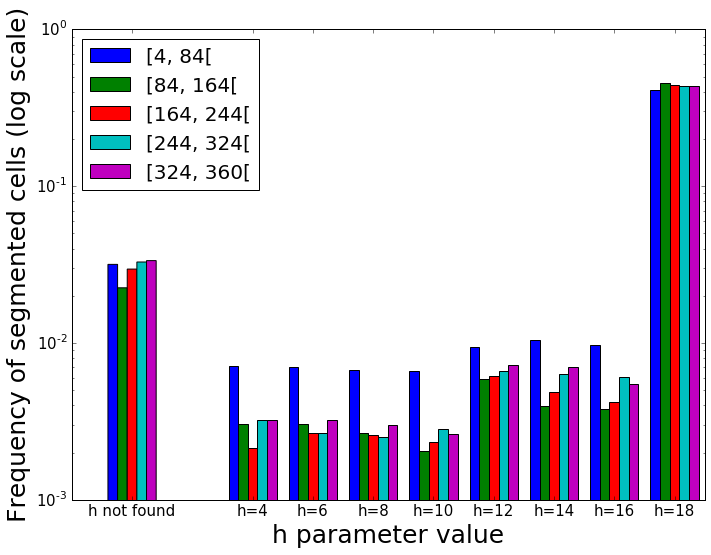

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
tmp = ax.hist(outputs, range=(0, 20), bins=10, log=True, normed=True, 
              label=['['+str(v*2)+', '+str(min((v+size)*2, 180*2))+'[' for v in range(2, 181, size)])

ax.set_xticks([0+1]+range(4+1, 20+1, 2))
ax.set_xlim(-1, 20)
ax.set_xticklabels(['h not found'] + ['h=4', 'h=6', 'h=8', 'h=10', 'h=12', 'h=14', 'h=16', 'h=18'])
ax.tick_params(axis='y', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.set_xlabel('h parameter value', fontsize=25)
ax.set_ylabel('Frequency of segmented cells (log scale)', fontsize=25)
ax.legend(loc='upper left', fontsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'h_min_distrib_hist.pdf')

## Comparison of ASTEC segmentation to the manually corrected cells by U.-M. Fiuza
### Distribution of the dice scores for every single time point

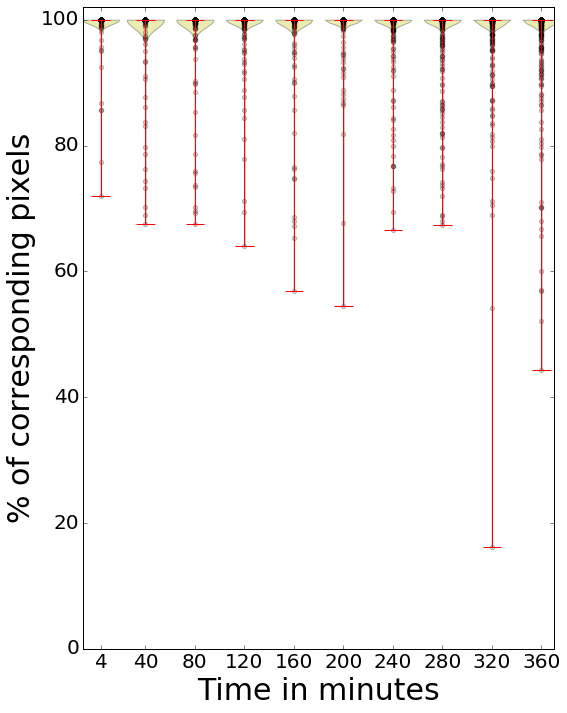

In [8]:
f = open(path_to_data + 'Supp-fig/2D-dice-scores-results.pkl')
dice_2D = pkl.load(f)
f.close()
valboxp=[]
times = dice_2D.keys()
times.sort()
for t in times:
        outputs=[]
        for vii in dice_2D[t]:
                outputs.extend(vii[-1])
        valboxp.append(np.array(outputs)*100)

fig=plt.figure(figsize=(8, 10))
ax=fig.add_subplot(111)
ax.violinplot(valboxp, positions=np.array(times)*2, widths=30)
ax.set_ylim(0, 102)
for i, vp in enumerate(valboxp):
    ax.scatter([times[i]*2]*len(vp), vp, color='k', alpha=.2)
ax.set_xlim(-10, 370)
ax.set_xticks(list(np.array(times)*2))
ax.set_yticks(range(0, 101, 20))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time in minutes', fontsize=30)
ax.set_ylabel('% of corresponding pixels', fontsize=30)
fig.tight_layout()
fig.savefig(p_to_figures + 'correspondance_distrib_by_time.pdf')

### Global distribution of the dice-scores

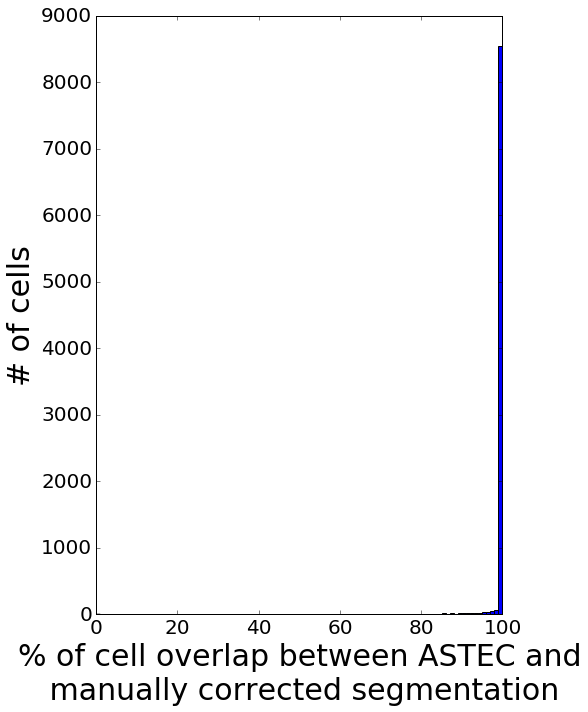

In [9]:
outputs=[]
for vi in dice_2D.values():
    for vii in vi:
        #nb_cells[-1]+=[len(vii[-1])]
        outputs.extend(vii[-1])
    
outputs = 100*np.array(outputs)
fig=plt.figure(figsize=(8, 10))
ax=fig.add_subplot(111)
ax.hist(outputs, bins=100, range=(0, 100))
ax.set_xlim(0, 100)
ax.set_xlabel('% of cell overlap between ASTEC and\n manually corrected segmentation', fontsize=30)
ax.set_ylabel('# of cells', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'correspondance_distrib_all_black.pdf')

# Morphological attributes of the cells

In [10]:
#Creation of the folder where the figures will be outputed
p_to_figures = path_to_figures + 'Morphological_attributes_of_the_cells/'
if not os.path.exists(p_to_figures):
    os.makedirs(p_to_figures)

## Distribution of the evolution of volume before and after the division

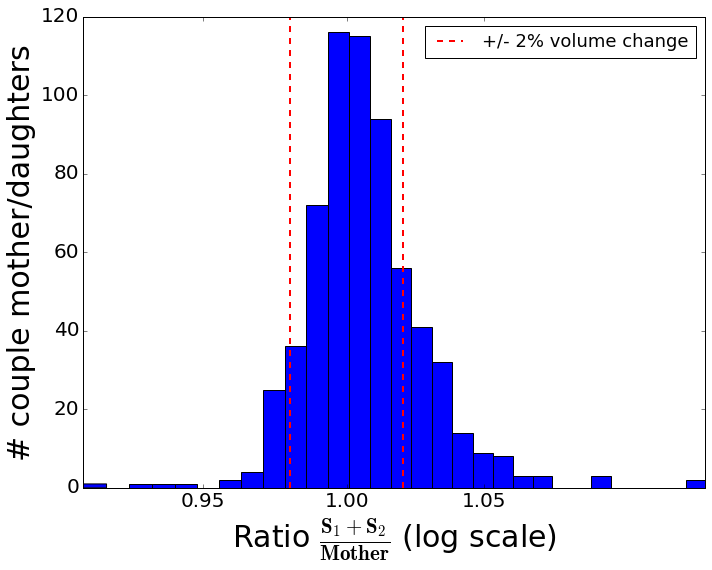

In [11]:
ratio_daugthers = [get_ratio_mother_sisters_volume(c, vol, lin_tree, inv_lin_tree, 5) 
                   for c, v in lin_tree.iteritems() if len(v) == 2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.hist(ratio_daugthers, bins=30)
ax.set_xscale('log')
ax.set_xlim(np.min(ratio_daugthers), np.max(ratio_daugthers))
ax.plot([0.98, 0.98], [0, 120], 'r--', lw=2, label='+/- 2% volume change')
ax.plot([1.02, 1.02], [0, 120], 'r--', lw=2)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([.95, 1, 1.05])
ax.set_xlabel(r'Ratio $\frac{\mathbf{S}_1 + \mathbf{S}_2}{\mathbf{Mother}}$ (log scale)', fontsize=30)
ax.set_ylabel('# couple mother/daughters', fontsize=30)
fig.tight_layout()
fig.savefig(p_to_figures + 'volume_ratio_sister_mother.pdf')

## Left/Right comparison of cell volumes

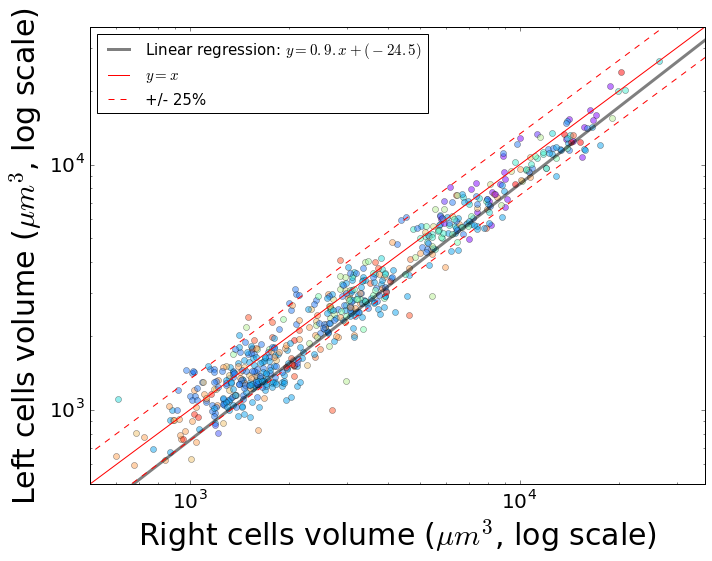

In [12]:
mother_cells = [c for c, v in inv_lin_tree.iteritems() if len(lin_tree[v]) == 2]
couples = []
for c in mother_cells:
    if names[c][-1]=='*':
        for ci in mother_cells:
            if names[c][:-1]==names[ci][:-1] and c!=ci:
                couples.append((c, ci))

X = []
Y = []
C = []
for cs in couples:
    x, y = get_symetric_volumes(cs, vol, lin_tree)
    X.append(x*.3**3)
    Y.append(y*.3**3)
    C.append(cs[0])
                

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
for c, x, y in zip(C, X, Y):
    ax.plot(x, y, 'o', color = CMapFates(fates3.get(c, 'undeter')), alpha=.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
ax.plot([100, 10**5], [slope*100+intercept, slope*10**5+intercept], 'k-', lw=3, alpha=.5,
        label=r'Linear regression: $y=%10.1f.x+(%10.1f)$'%(slope,+intercept))

ax.set_yscale('log')
ax.set_xscale('log')
ax.plot([100, 10**5], [100, 10**5], 'r-', label=r'$y=x$')
ax.plot([100, 10**5], [0.75*100, 0.75*10**5], 'r--', label='+/- 25%')
ax.plot([100, 10**5], [(1/0.75)*100, (1/0.75)*10**5], 'r--')
ax.set_xlim(np.min(X+Y)-100, np.max(X+Y)+10000)
ax.set_ylim(np.min(X+Y)-100, np.max(X+Y)+10000)
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel(r'Right cells volume ($\mu m^3$, log scale)', fontsize=30)
ax.set_ylabel(r'Left cells volume ($\mu m^3$, log scale)', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'volume_ratio_left_right.pdf')

## Cell compactness around division events

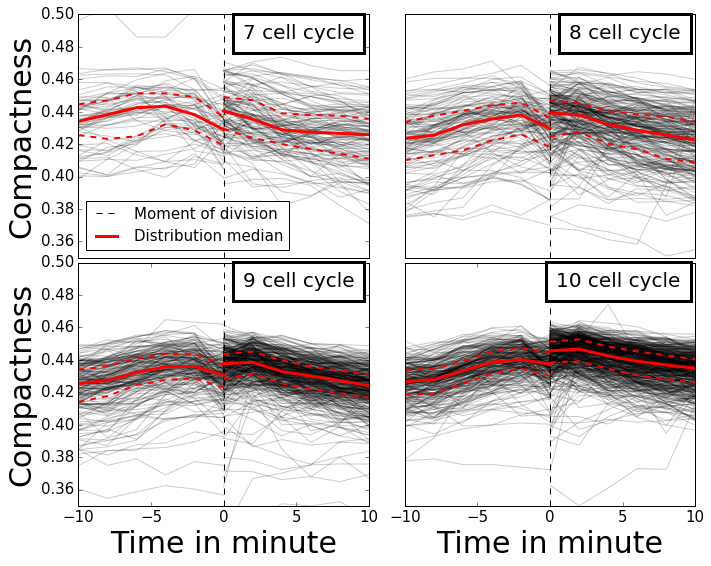

In [13]:
comp = properties['compactness'][0]
interest_cells = [c for c, v in lin_tree.iteritems() if len(v) == 2]
plot_around_div(comp, lin_tree, inv_lin_tree, interest_cells, names, col=2, row=2, ylim=(0.35, 0.5),
                saving_folder=p_to_figures, x_label='Time in minute', y_label='Compactness', around=5)

# Comparison between ASTEC and Faure et al. lineage trees

In [14]:
#Creation of the folder where the figures will be outputed
p_to_figures = path_to_figures + 'ASTEC_vs_Faure/'
if not os.path.exists(p_to_figures):
    os.makedirs(p_to_figures)

## Specific data loading
Those data contains the croped and rescaled lineage trees from Faure et al. and ASTEC so their time-resolution and development coverage are similar

In [15]:
f=open(path_to_data + 'Comparison_to_Faure_et_al/lin_trees.pkl')
datas=pkl.load(f)
f.close()

names_em=datas['names_em']
names_ASTEC=datas['names']


## As described in the paper the naming is an issue
## Therefore we have to manually adjust the names
names_to_change=[('a8.0011', 'a8.0012')]
for n1, n2 in names_to_change:
    t_c1=[c for c in lin_tree.keys() if n1 in names[c]]
    t_c2=[c for c in lin_tree.keys() if n2 in names[c]]
    for c in t_c1:
        names_ASTEC[c]=n2+names_ASTEC[c][-1]
    for c in t_c2:
        names_ASTEC[c]=n1+names_ASTEC[c][-1]


f=open(path_to_data + 'Comparison_to_Faure_et_al/crossed_scores.pkl')
crossed_scores, Faure_scores, ASTEC_scores=pkl.load(f)
f.close()

## Plot of the bilateral and overall pairwise lineage distances for ASTEC

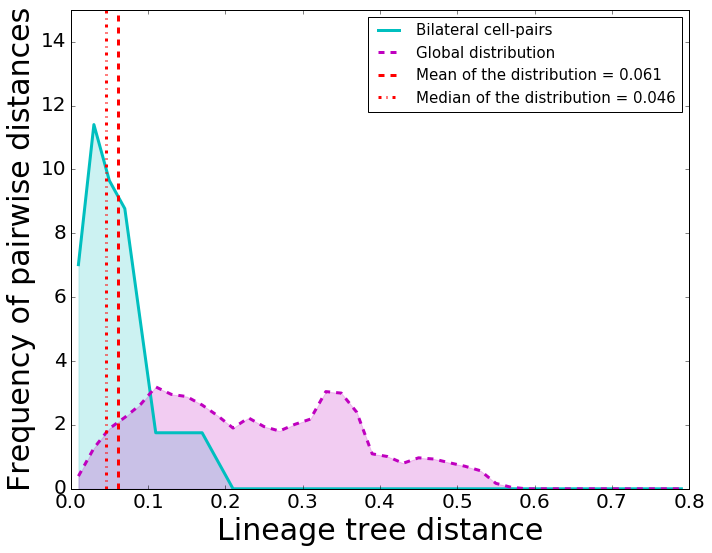

In [16]:
comp_trees_same={}
for c1, c2, v in ASTEC_scores:
    if (names_ASTEC[c1][:-1]==names_ASTEC[c2][:-1]):
        comp_trees_same[c1]=v    
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
X, Y = get_x_y(comp_trees_same.values(), bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'c-', lw=3, label='Bilateral cell-pairs')
ax.fill_between(X, Y, color='c', alpha=.2)

X, Y = get_x_y(ASTEC_scores, bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'm--', lw=3, label='Global distribution')
ax.fill_between(X, Y, color='m', alpha=.2)

mean_g = np.mean(comp_trees_same.values())
median_g = np.median(comp_trees_same.values())
ax.plot([mean_g, mean_g], [0, 15], 'r--', lw=3, 
        label='Mean of the distribution = '+str(np.around(mean_g, 3)))
ax.plot([median_g, median_g], [0, 15], 'r-.', lw=3, 
        label='Median of the distribution = '+str(np.around(median_g, 3)))
ax.set_xlim((0,0.8))
ax.set_ylim((0,15))
ax.set_ylabel('Frequency of pairwise distances', fontsize=30)
ax.set_xlabel('Lineage tree distance', fontsize=30)
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'cell_lin_tree_scores_ASTEC.pdf')

## Plot of the bilateral and overall pairwise lineage distances for Faure et al.

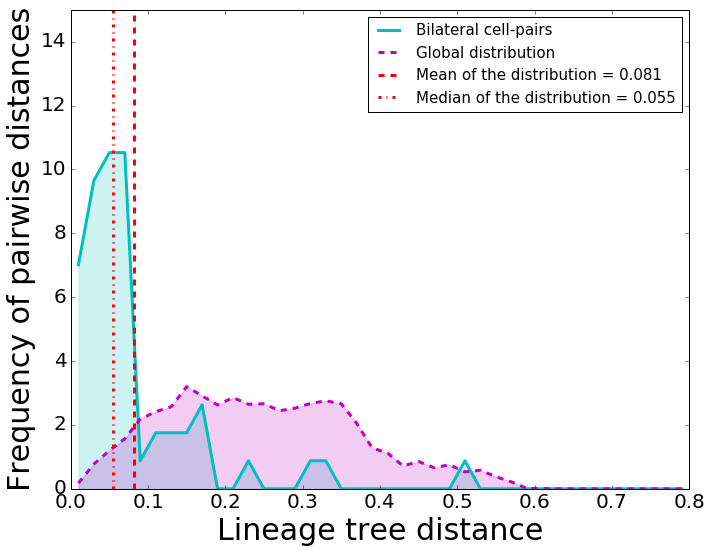

In [17]:
comp_trees_same={}
for c1, c2, v in Faure_scores:
    if (names_em[c1][:-1]==names_em[c2][:-1]):
        comp_trees_same[c1]=v

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
X, Y=get_x_y(comp_trees_same.values(), bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'c-', lw=3, label='Bilateral cell-pairs')
ax.fill_between(X, Y, color='c', alpha=.2)

X, Y=get_x_y(Faure_scores, bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'm--', lw=3, label='Global distribution')
ax.fill_between(X, Y, color='m', alpha=.2)

mean_g=np.mean(comp_trees_same.values())
median_g=np.median(comp_trees_same.values())
ax.plot([mean_g, mean_g], [0, 15], 'r--', lw=3, 
        label='Mean of the distribution = '+str(np.around(mean_g, 3)))
ax.plot([median_g, median_g], [0, 15], 'r-.', lw=3, 
        label='Median of the distribution = '+str(np.around(median_g, 3)))
ax.set_xlim((0,0.8))
ax.set_ylim((0,15))
ax.set_ylabel('Frequency of pairwise distances', fontsize=30)
ax.set_xlabel('Lineage tree distance', fontsize=30)
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'cell_lin_tree_scores_faure_et_al.pdf')

## Plot of the bilateral and overall pairwise lineage distances between ASTEC and Faure et al.

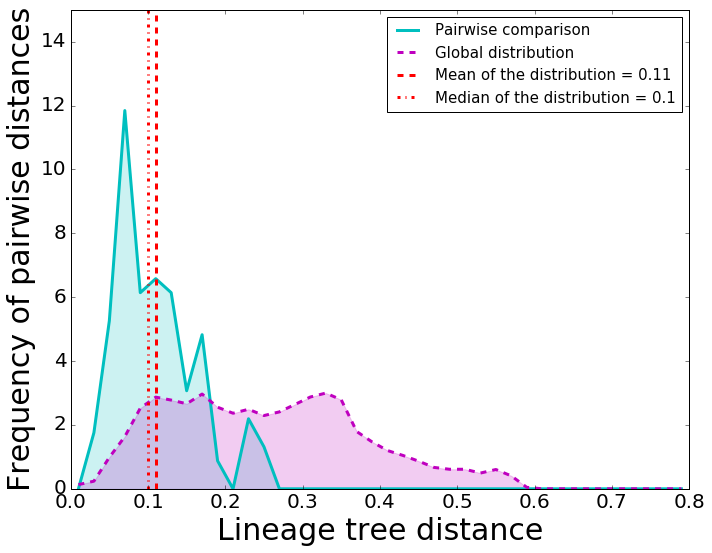

In [18]:
comp_trees_same={}
tmp = {}
for c1, c2, v in crossed_scores:
    if (names_ASTEC[c1][:-1]==names_em[c2][:-1] and 
        (v < comp_trees_same.get(c1, np.inf) and
         v < comp_trees_same.get(c2, np.inf))): 
        comp_trees_same[c1]=v
                
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)

X, Y=get_x_y(comp_trees_same.values(), bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'c-', lw=3, label='Pairwise comparison')
ax.fill_between(X, Y, color='c', alpha=.2)

X, Y=get_x_y(crossed_scores, bins=40, range=(0,.8), normed=True)
ax.plot(X, Y, 'm--', lw=3, label='Global distribution')
ax.fill_between(X, Y, color='m', alpha=.2)

ax.set_xlim((0,0.8))
ax.set_ylim((0,15))
mean_vs=np.mean(comp_trees_same.values())
median_vs=np.median(comp_trees_same.values())
ax.plot([mean_vs, mean_vs], [0, 15], 'r--', lw=3, 
        label='Mean of the distribution = '+str(np.around(mean_vs, 3)))
ax.plot([median_vs, median_vs], [0, 15], 'r-.', lw=3, 
        label='Median of the distribution = '+str(np.around(median_vs, 3)))
ax.legend(fontsize=15)
ax.set_ylabel('Frequency of pairwise distances', fontsize=30)
ax.set_xlabel('Lineage tree distance', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + 'cell_lin_tree_scores_faure_et_al_vs_ASTEC.pdf')
plt.show()


# Pairwise comparison between lineage trees
This part plot the pairwise distances between the different lineages of ASTEC result gathering them by L/R symmetry or fate.

In [19]:
#Creation of the folder where the figures will be outputed
p_to_figures = path_to_figures + 'lin_comparison/'
if not os.path.exists(p_to_figures):
    os.makedirs(p_to_figures)
    
#Loading of the lineage tree distances
f=open(path_to_data+'sim_LR.pkl')
tree_distances=pkl.load(f)
f.close()

starting_time=2
tree_distances={(2*10**4+k[0], 2*10**4+k[1]):v 
                for k, v in tree_distances}

def compare_fates(k1, k2, f, f1, f2=''):
    """ Check whether two given cells fates names contains a two given string
        according to a given fate dictionary
        Args:
            k1(int): cell id of the first cell
            k2(int): cell id of the second cell
            f(dict): dictionary containing the fate informations
            f1(string): first fate name
            f2(string): second fate name
        Returns:
            (bool): True if k1 and k2 belongs to f1 and f2 (regardless of the order)
    """
    if f2=='': f2=f1
    return ((f1 in f.get(k1, '') and
             f2 in f.get(k2, '')) or
            (f2 in f.get(k1, '') and
             f1 in f.get(k2, '')))

## Computation of the different interesting distributions (that are all subset of the global distribution)

In [20]:
f_pp=fates3 #All the fate considered come from the fates3 dictionary

#Pairwise distances for couple of cells that:
not_same = {}                      # have different fate names
tree_distance_identical_fate={}    # have identical fate names
tree_distance_Epi_Epi={}           # have fate names that contains the string 'Epidermis'
tree_distance_Neuro_Neuro={}       # have fate names that contains the string 'Neural'
tree_distance_Epi_Endo={}          # are Neural or Epidermis
tree_distance_Epi_Meso={}          # are Mesodermal or Epidermis
tree_distance_Epi_NP={}            # are Epidermis or Neural
tree_distance_Endo_Meso={}         # are Endodermal or Mesendodermal
tree_distance_Endo_NP={}           # are Endodermal or Neural
tree_distance_Meso_NP={}           # are Mesodermal
tree_distance_similar_fate={}
tree_distance_less_similar_fate={}
tree_distance_diff_fate={}
tree_distance_bilat={}
tree_distance_with_gl={}
tree_distance_unknown={}

for k, v in tree_distances.iteritems():
    if names[k[0]][:-1]==names[k[1]][:-1]:
        tree_distance_bilat[(k[0], k[1])]=v
    elif f_pp.get(k[0], '0')==f_pp.get(k[1], '1'):
        tree_distance_identical_fate[(k[0], k[1])]=v
        if 'Epidermis' in f_pp.get(k[0], '0'):
            tree_distance_Epi_Epi[(k[0], k[1])]=v
        elif 'Neural' in f_pp.get(k[0], '0'):
            tree_distance_Neuro_Neuro[(k[0], k[1])]=v
    elif (compare_fates(k[0], k[1], f_pp, 'Endoderm') or
          compare_fates(k[0], k[1], f_pp, 'Epidermis') or
          compare_fates(k[0], k[1], f_pp, 'Neural Plate') or
          compare_fates(k[0], k[1], f_pp, 'Mesoderm')):
          tree_distance_similar_fate[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Epidermis', 'Endoderm'):
        tree_distance_Epi_Endo[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Epidermis', 'Mesoderm'):
        tree_distance_Epi_Meso[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Epidermis', 'Neural Plate'):
        tree_distance_Epi_NP[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Endoderm', 'Mesoderm'):
        tree_distance_Endo_Meso[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Endoderm', 'Neural Plate'):
        tree_distance_Endo_NP[(k[0], k[1])]=v
    elif compare_fates(k[0], k[1], f_pp, 'Neural Plate', 'Mesoderm'):
        tree_distance_Meso_NP[(k[0], k[1])]=v
    elif (fates3.get(k[0], '')=='Germline' or
          fates3.get(k[1], '')=='Germline'):
        tree_distance_with_gl[(k[0], k[1])]=v
    elif (fates3.get(k[0], '')=='' or
          fates3.get(k[1], '')==''):
        tree_distance_unknown[(k[0], k[1])]=v
    if not f_pp.get(k[0], '0')==f_pp.get(k[1], '1'):
        not_same[(k[0], k[1])]=v
    tree_distance_diff_fate[(k[0], k[1])]=v
      

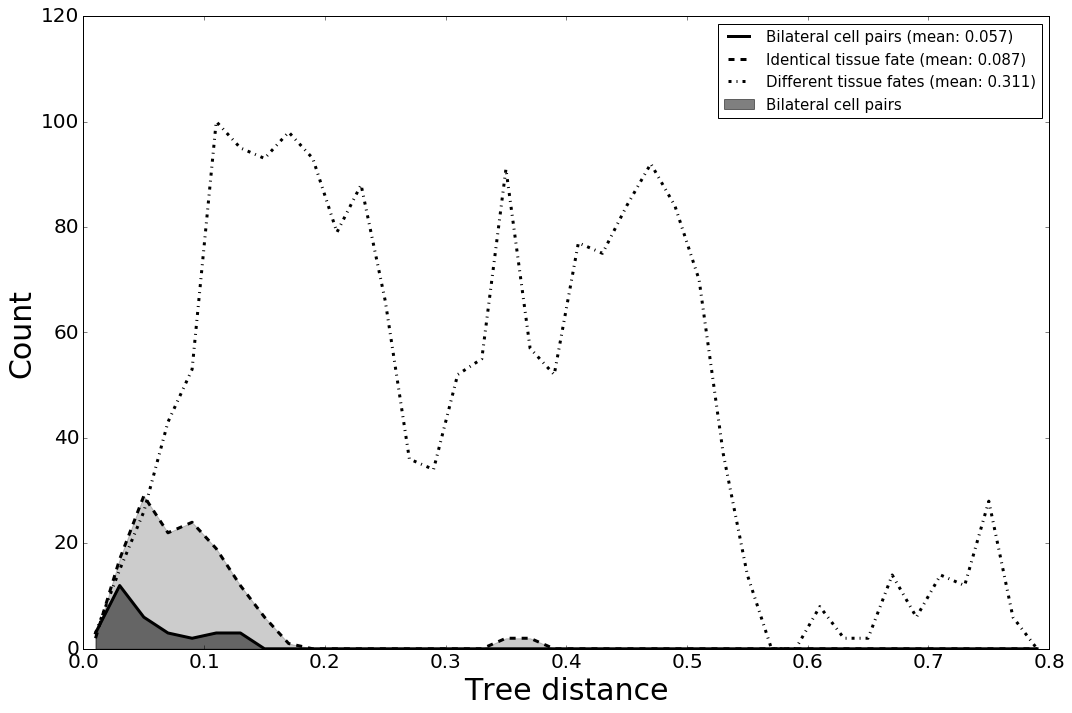

In [21]:
bins=40
range_hist=(0, 0.8)
i=0
grey=np.array([.1,.1,.1])
cmap_c=ColorMap(range(7), 'jet')
fig=plt.figure(figsize=(15, 10))
ax=fig.add_subplot(111)
X, Y = get_x_y(tree_distance_bilat.values(), bins, range_hist, normed=False)
ax.plot(X, Y, 'k-', lw=3, 
        label='Bilateral cell pairs (mean: ' +str(np.around(np.mean(tree_distance_bilat.values()), 3))+')')
ax.fill_between(X, Y, color='k', alpha=.5, label='Bilateral cell pairs')

X, Y = get_x_y(tree_distance_identical_fate.values(), bins, range_hist, normed=False)
ax.plot(X, Y, 'k--', lw=3, 
        label='Identical tissue fate (mean: ' +str(np.around(np.mean(tree_distance_identical_fate.values()), 3))+')')
ax.fill_between(X, Y, color='k', alpha=.2)

X, Y=get_x_y(not_same.values(), bins, range_hist, normed=False)
ax.plot(X, Y, 'k-.', lw=3, 
        label='Different tissue fates (mean: ' +str(np.around(np.mean(not_same.values()), 3))+')')
#ax.fill_between(X, Y, color=grey, alpha=.2)

ax.set_ylim(0, 120)
ax.set_xlim(0, .8)
ax.set_ylabel('Count', fontsize=30)
ax.set_xlabel('Tree distance', fontsize=30)
ax.legend(fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig(p_to_figures + '/lin_tree_distances.pdf')

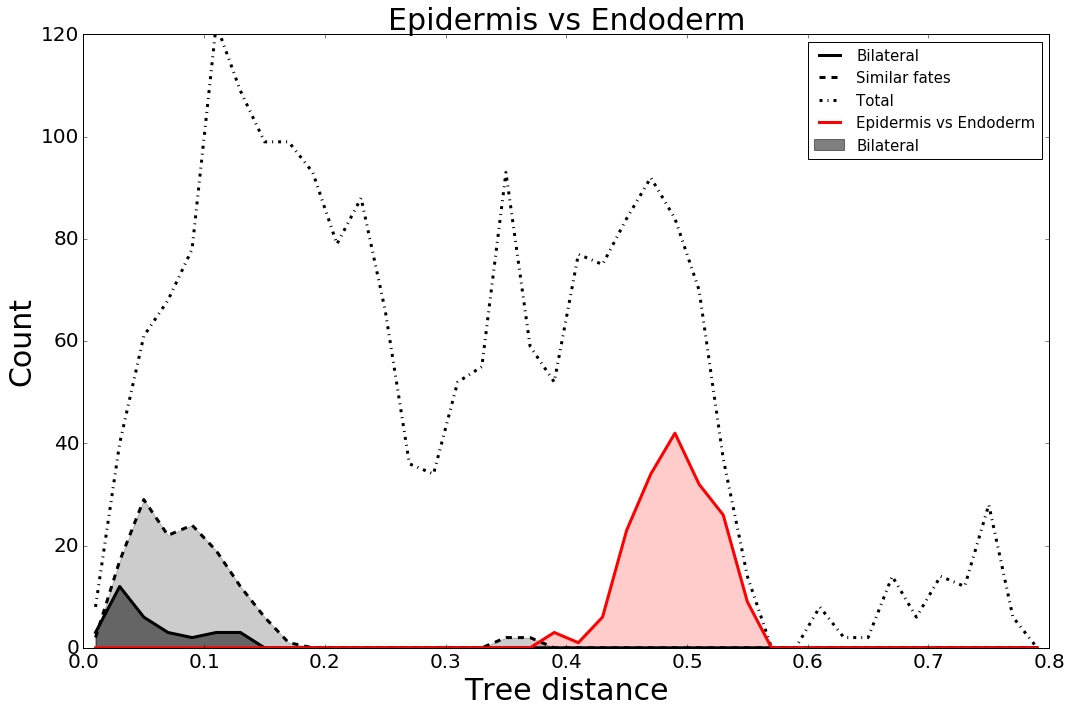

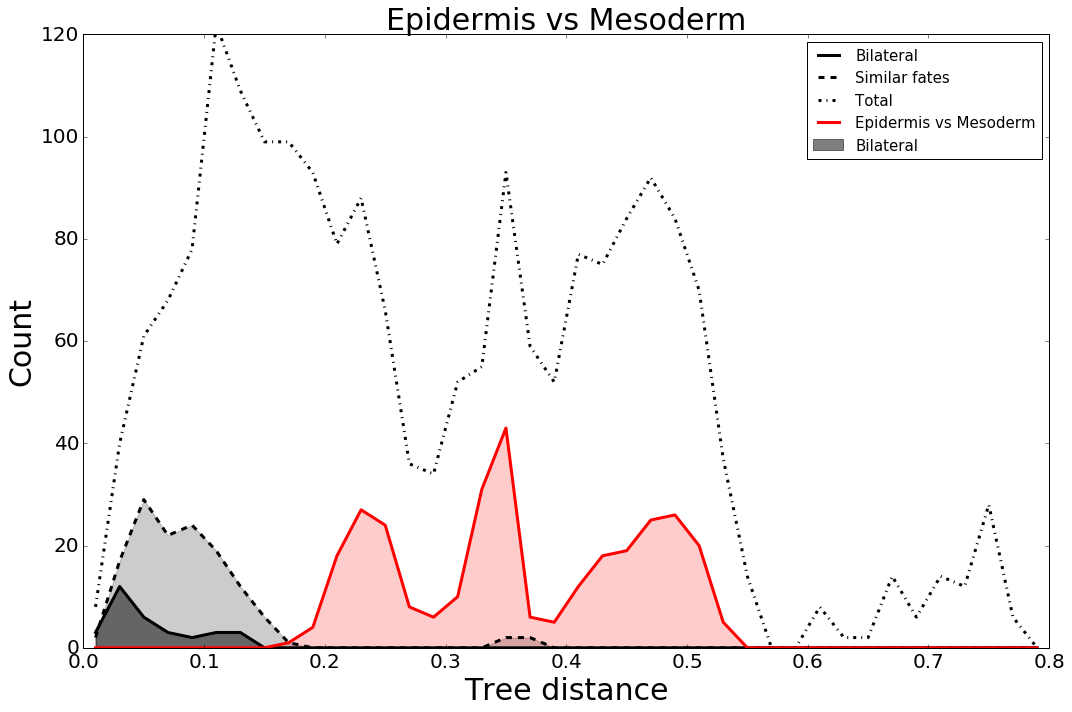

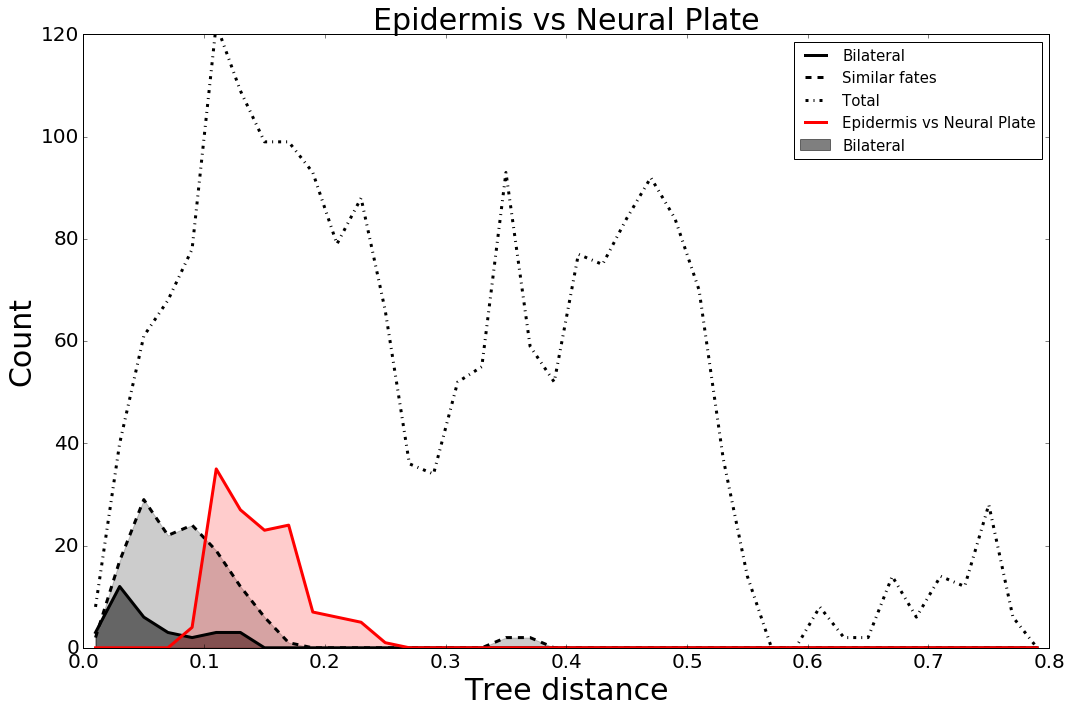

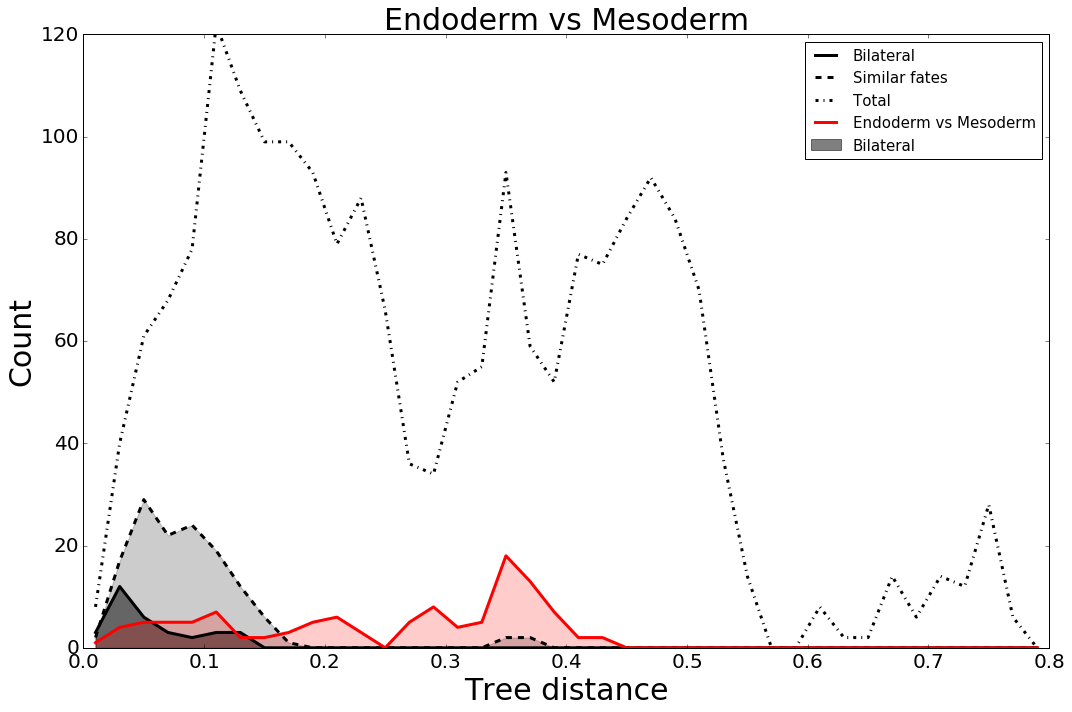

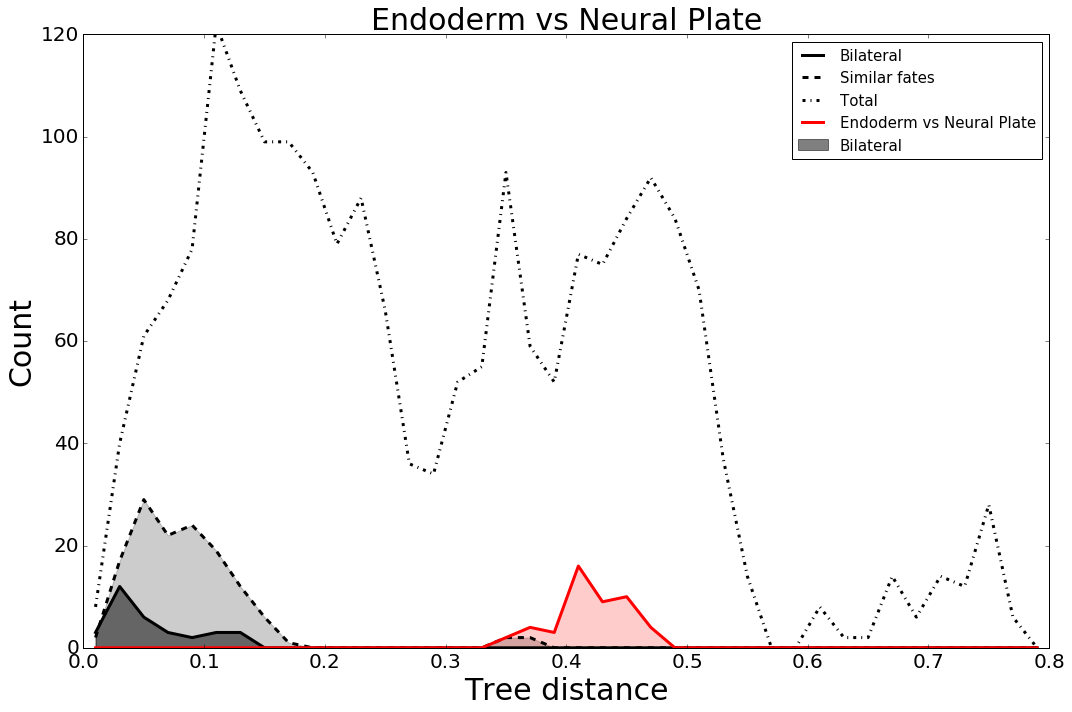

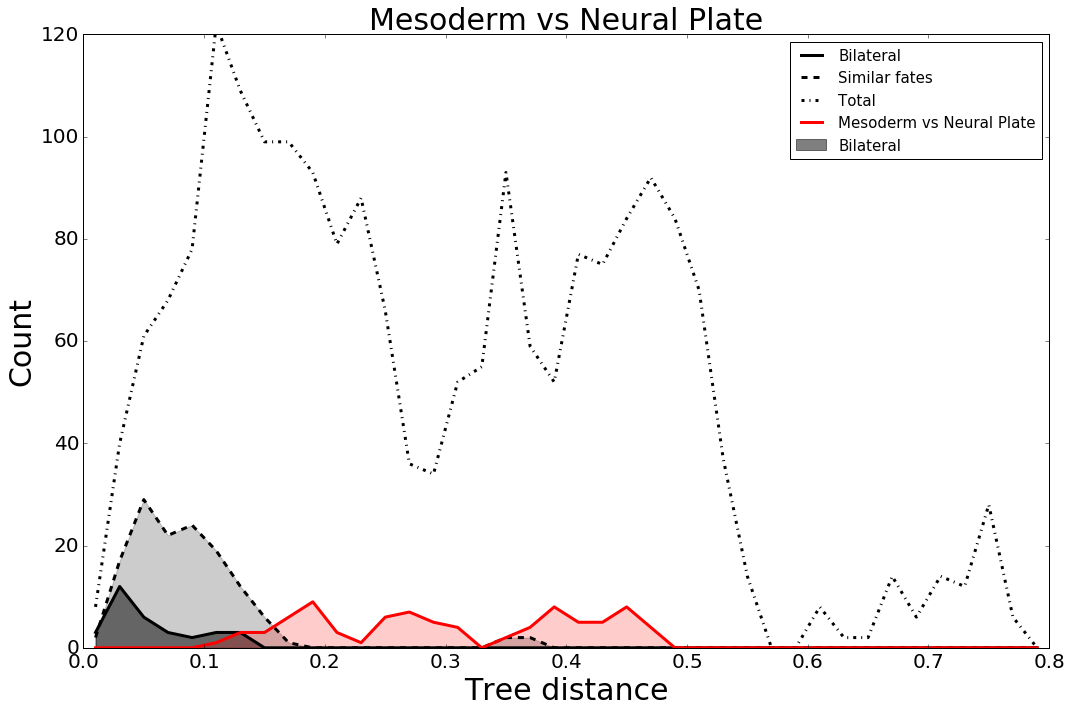

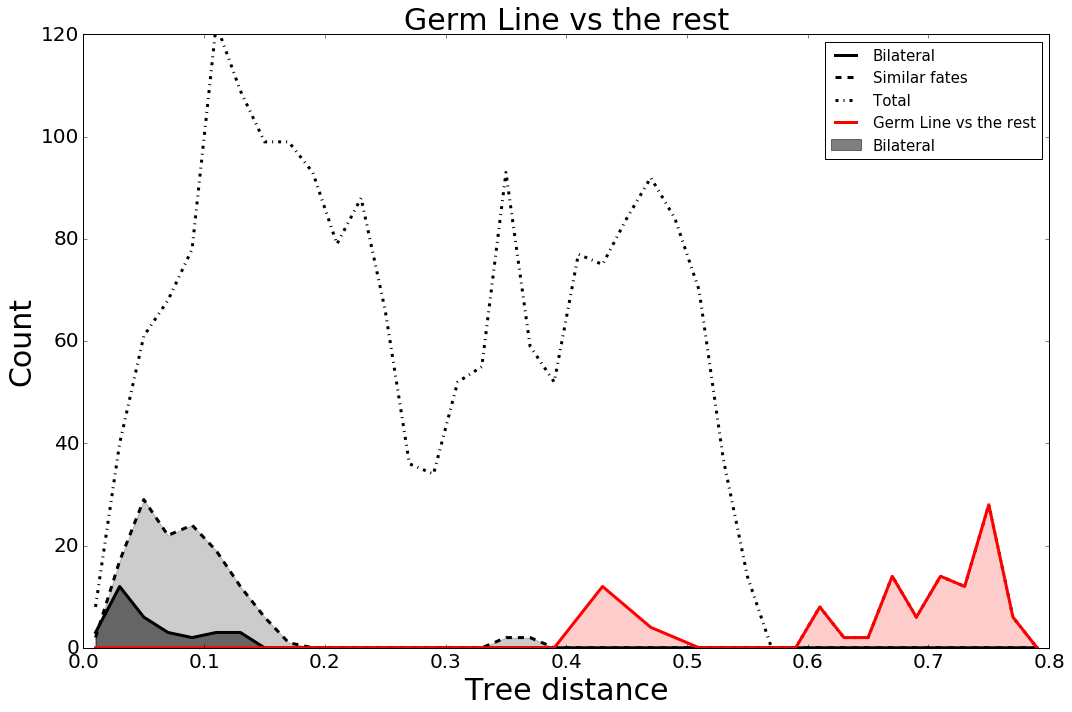

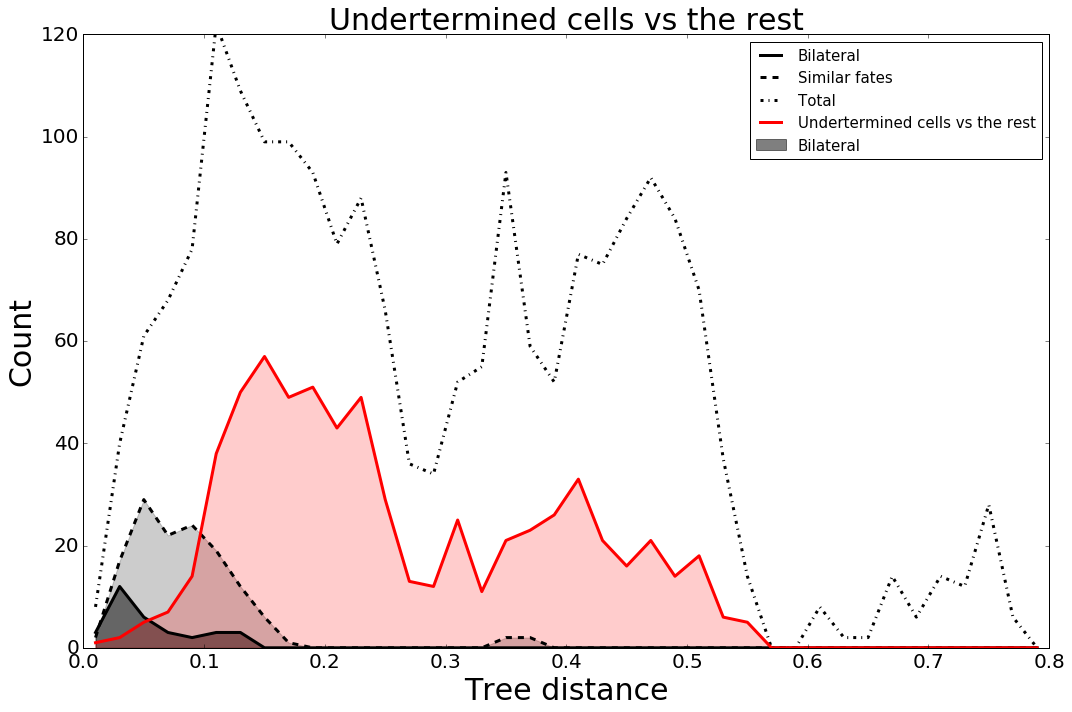

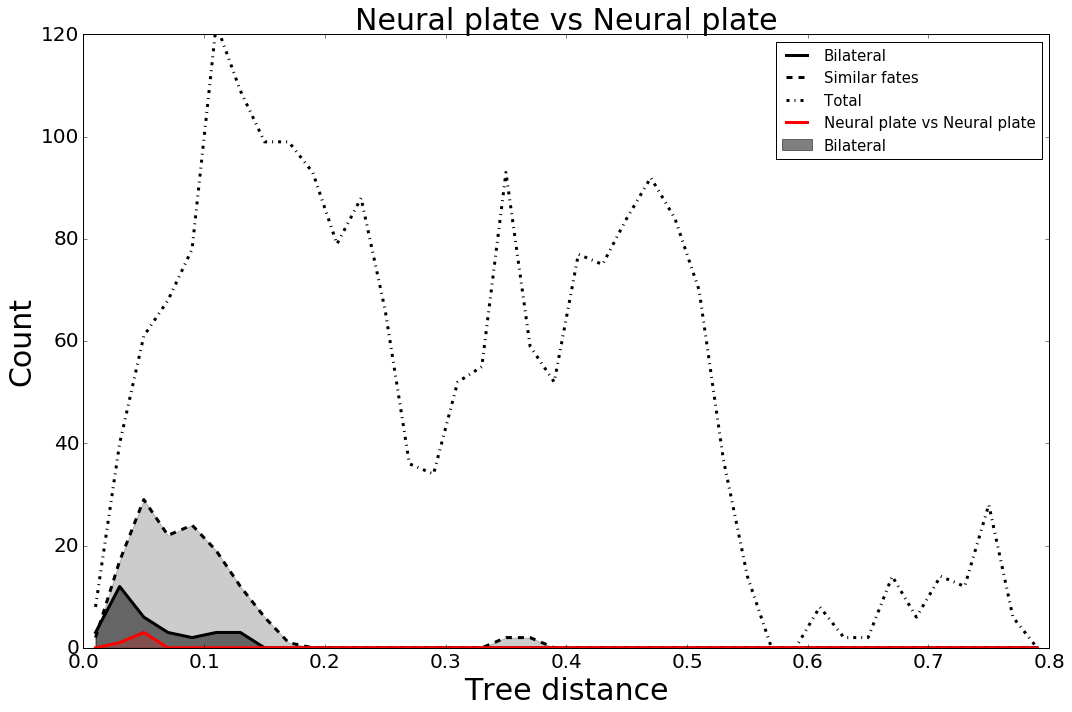

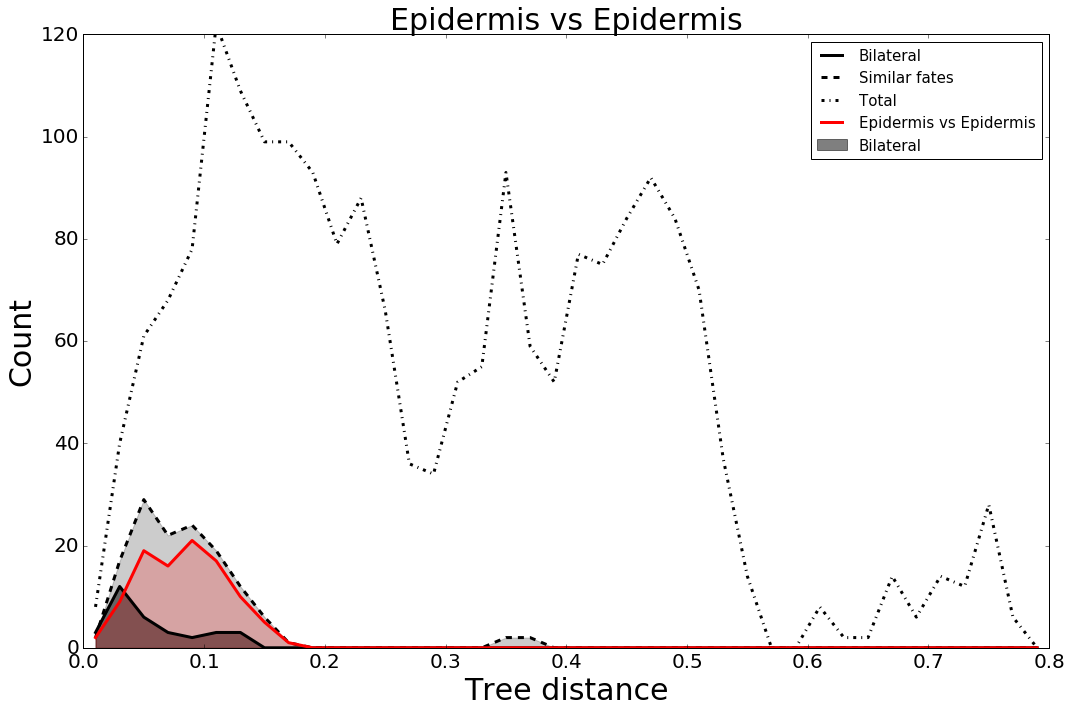

In [22]:
tmp = [tree_distance_Epi_Endo,
        tree_distance_Epi_Meso,
        tree_distance_Epi_NP,
        tree_distance_Endo_Meso,
        tree_distance_Endo_NP,
        tree_distance_Meso_NP,
        tree_distance_with_gl,
        tree_distance_unknown,
        tree_distance_Neuro_Neuro,
        tree_distance_Epi_Epi]

tmp_names = [
    'Epidermis vs Endoderm',
    'Epidermis vs Mesoderm',
    'Epidermis vs Neural Plate',
    'Endoderm vs Mesoderm',
    'Endoderm vs Neural Plate',
    'Mesoderm vs Neural Plate',
    'Germ Line vs the rest',
    'Undertermined cells vs the rest',
    'Neural plate vs Neural plate',
    'Epidermis vs Epidermis'
]

for v, n in zip(tmp, tmp_names):
    bins = 40
    range_hist = (0, 0.8)
    i = 0
    grey=np.array([.1,.1,.1])
    cmap_c=ColorMap(range(7), 'jet')
    fig=plt.figure(figsize=(15, 10))
    ax=fig.add_subplot(111)
    X, Y=get_x_y(tree_distance_bilat.values(), bins, range_hist, normed = False)
    ax.plot(X, Y, 'k-', lw=3, label='Bilateral')
    ax.fill_between(X, Y, color='k', alpha=.5, label='Bilateral')

    X, Y = get_x_y(tree_distance_identical_fate.values(), bins, range_hist, normed = False)
    ax.plot(X, Y, 'k--', lw=3, label='Similar fates')
    ax.fill_between(X, Y, color='k', alpha=.2)

    X, Y = get_x_y(tree_distance_diff_fate.values(), bins, range_hist, normed = False)
    ax.plot(X, Y, 'k-.', lw=3, label='Total')
    #ax.fill_between(X, Y, color=grey, alpha=.2)

    X, Y=get_x_y(v.values(), bins, range_hist)
    ax.plot(X, Y, 'r-', lw=3, label=n)
    ax.fill_between(X, Y, color='r', alpha=.2)

    
    ax.set_ylim(0, 120)
    ax.set_xlim(0, .8)
    ax.set_ylabel('Count', fontsize=30)
    ax.set_xlabel('Tree distance', fontsize=30)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(n, fontsize=30)
    fig.tight_layout()
    fig.savefig(p_to_figures + '/lin_tree_distances_'+n+'.pdf')


## Performs a hierarchical clustering on the lineage tree distances

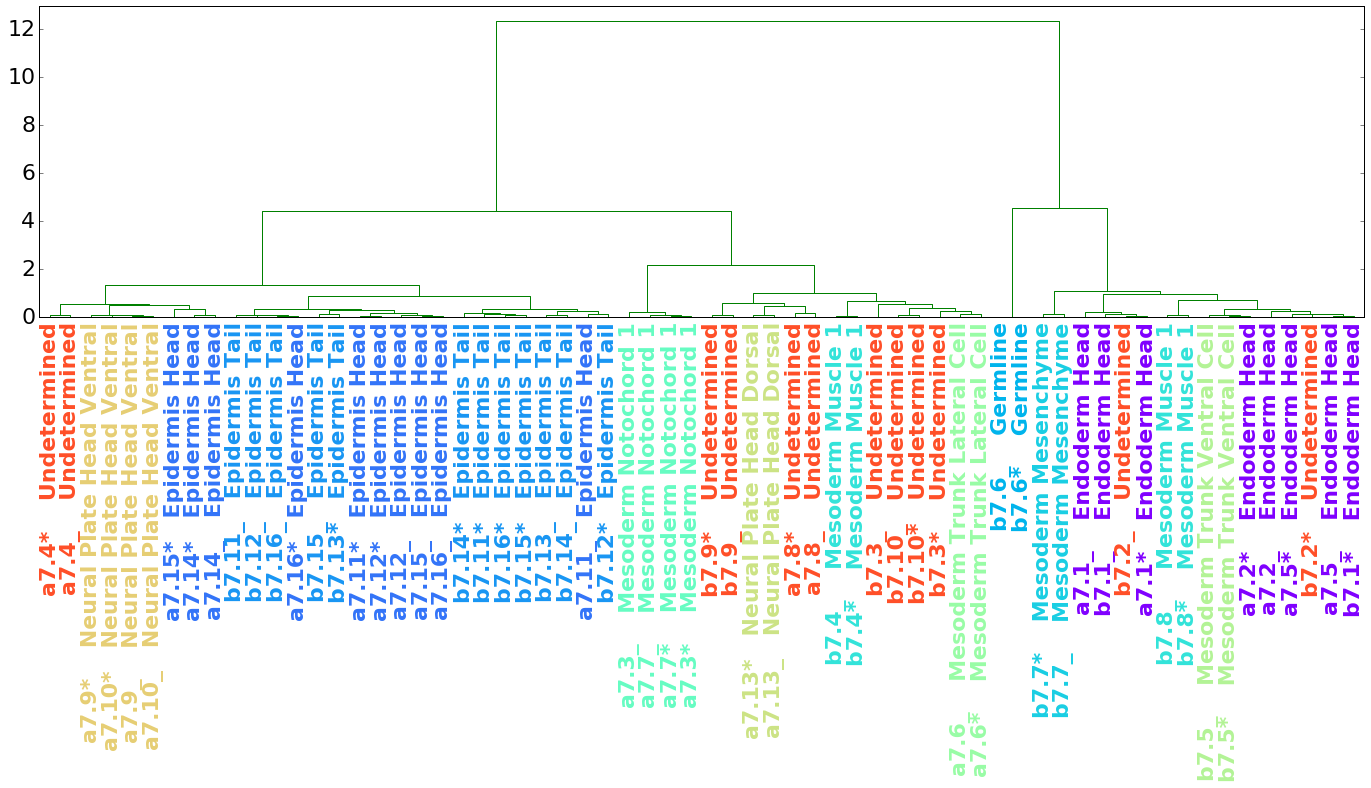

In [23]:
Y, corres, corres_inv=build_distance_matrix(tree_distances)
perform_and_plot_dendrogram(Y, corres, corres_inv, fates3, ColorMap, names,
                            method='ward', saving_folder=p_to_figures, 
                            distance_name='Division pattern clustering',
                            color_threshold=100)

# Analysis of cell division that give rise to different daughters

In [7]:
#Creation of the folder where the figures will be outputed
p_to_figures = path_to_figures + 'Assy_div/'
if not os.path.exists(p_to_figures):
    os.makedirs(p_to_figures)

For this part we want to take the most of the segmentation that we have in hand. To do so we decided to extend one division backward our lineage tree. This is what the `generate_32_cell_stage` function does.

We therefore add an artificial mother to all sister cells from the first time point of the movie.

These artificial mothers have as volume the sum of the volume of their two sisters.

They have as lineage tree distance the distance between the two sisters (this distance is stored in Data/sim_LR.pkl that were used in the "Pairwise comparison between lineage trees".).

More over the dictionary that contains the distances between sister lineage trees is not directly given by the `loading_data` function. Hence the use of
```python
sim_nv = properties['Sim no vol'][0]
```

`sim_nv` dictionary maps a cell id to the lineage tree distance to its sister as described in the article:
```python
sim_nv = {cell_id(int): distance(float), ...}
```
More over if a cell `c` is about to divide, ie
```python
len(lin_tree[c]) == 2
```
then
```python
sim_nv[c] == sim_nv[lin_tree[c][0]] == sim_nv[lin_tree[c][1]]
```
(this is a remnant of other uses)

In [4]:
f=open(path_to_data+'sim_LR.pkl')
sim_tree = pkl.load(f)
f.close()

# dictionary of the distances between sister lineage trees
sim_nv = properties['Sim no vol'][0]

cells = [k for k in lin_tree.keys() if k/10**4==1]
for c in cells:
    vol[c] = vol[lin_tree[c][0]]

new_lin_tree, new_names, new_vol, new_sim_nv = generate_32_cell_stage(lin_tree, names,
                                                                      inv_lin_tree, sim_tree, sim_nv, vol)

new_inv_lin_tree={ v : k for k, values in new_lin_tree.iteritems() for v in values }

In order to build the following plots, cell divisions events are first cherry picked and then are classified twice (once for each figure).

The cherry pick is done the same way as it is in the cell-cell interation model, all cell division event is represented by its mother cell. The mother cells that are choose are the ones in their $8^{th}$ zygotic cell-cycle or less.

Then, two groups are built by the first classification, "Known specification events" (K) and "No known specification events" (NK). This classification relies on manual annotation of cell division events known to end in cell specification events (from the litterature):
```python
cells_with_spec = ['a6.2', 'a6.3', 'a6.4', 'a6.7', 'b6.2', 'b6.4', 'b6.3',
                   'a7.8', 'a7.9', 'a7.10', 'a7.13', 'b7.3', 'b7.9', 'b7.10'
                   'a8.7', 'a8.8', 'a8.17', 'a8.19', 'a8.25', 'a8.16', 'a8.15']
```

Finally four groups are built by the second classification. Those groups are the cross product of the two following set of two groups:
- "No expected cell specification" (NS) and "Expected cell specification" (S)
- "Equal division" (E) and "Unequal division" (U)

A cell division event is in is in (NS) if the two daugthers have lineage distance smaller than $0.1$ and their fates according to ```fates3``` are determined and identical. The division event is classified as (S) otherwise.

A cell division event is in is in (E) if the volume ratio between the two sister cells is under $1.3$. The cell division event is classified (U) otherwise

In [5]:
equal_div = []
unequal_div = []
lin_dist_values_to_find = {}
lin_dist_values_not_to_find = {}
cells_with_spec = ['a6.2', 'a6.3', 'a6.4', 'a6.7', 'b6.2', 'b6.4', 'b6.3',
                   'a7.8', 'a7.9', 'a7.10', 'a7.13', 'b7.3', 'b7.9', 'b7.10'
                   'a8.7', 'a8.8', 'a8.17', 'a8.19', 'a8.25', 'a8.16', 'a8.15']

# Cherry picking
z_c_end = 9
time_end = 180
interest_cells=[c for c in new_lin_tree.keys() if (c/10**4<time_end and
                                                   len(new_lin_tree[c])==2 and
                                                   int(new_names[new_lin_tree[c][0]].split('.')[0][1:])<=z_c_end)]

# Right-left gathering
couples=[]
for c in interest_cells:
    if new_names[c][-1] == '_':
        for ci in interest_cells:
            if new_names[c][:-1] == new_names[ci][:-1] and c!=ci:
                couples.append((c, ci))

for c1, c2 in couples:
    mean_nv=np.mean([new_sim_nv[c1], new_sim_nv[c2]])
    ratio1=get_max_vol(c1, new_vol, new_lin_tree)/get_min_vol(c1, new_vol, new_lin_tree)
    ratio2=get_max_vol(c2, new_vol, new_lin_tree)/get_min_vol(c2, new_vol, new_lin_tree)
    mean_ratio=np.mean([ratio1, ratio2])
    

    if short_name(new_names[c1]) in cells_with_spec:
        lin_dist_values_to_find[new_names[c1]] = mean_nv # cell division event in (K)
    else:
        lin_dist_values_not_to_find[new_names[c1]] = mean_nv # cell division event in (NK)
        
    if mean_nv < .1 and fates3.get(new_lin_tree[c1][0], '1') == fates3.get(new_lin_tree[c1][1], '2'):
        if mean_ratio < 1.3:
            equal_div += [0] # cell division event in (NS) + (E)
        else:
            unequal_div += [1] # cell division event in (NS) + (U)
    else:
        if mean_ratio < 1.3:
            equal_div += [3] # cell division event in (S) + (E)
        else:
            unequal_div += [4] # cell division event in (S) + (U)

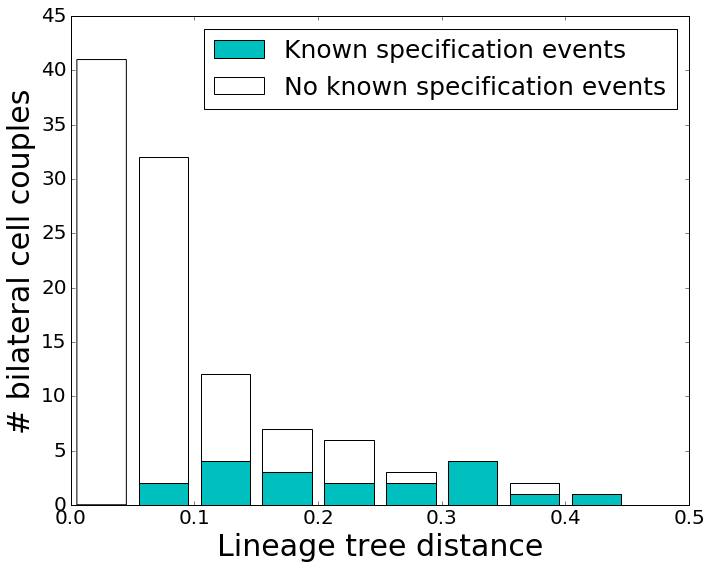

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.hist([lin_dist_values_to_find.values(), lin_dist_values_not_to_find.values()], histtype = 'barstacked',
        color = ['c', 'w'], range = (0, .5), bins=10, align = 'mid')
ax.legend(['Known specification events', 'No known specification events'], fontsize = 25)
ax.set_ylabel('# bilateral cell couples', fontsize = 30)
ax.set_xlabel('Lineage tree distance', fontsize = 30)
ax.set_xticklabels(np.arange(0, .6, .1), fontsize = 20)
ax.set_yticks(np.arange(0, 46, 5))
ax.set_yticklabels(np.arange(0, 46, 5), fontsize = 20)
fig.tight_layout()
plt.savefig(p_to_figures + 'sister_lineage_distances.pdf')

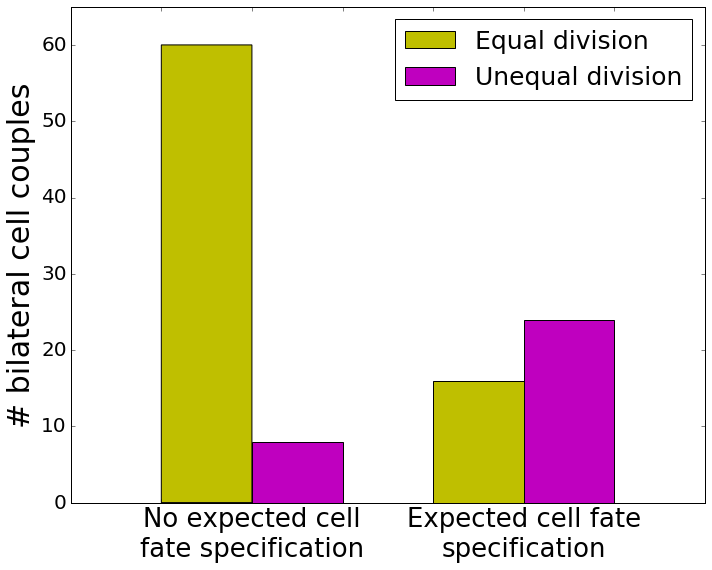

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.hist(equal_div, range=(0, 5), bins = 5, color='y', align='mid', label = 'Equal division')
ax.hist(unequal_div, range=(0, 5), bins = 5, color='m', align='mid', label = 'Unequal division')
ax.set_xticklabels(['', '', 'No expected cell\nfate specification', '', '', 'Expected cell fate\nspecification'], 
                   fontsize=26)
ax.set_xlim(-1, 6)
ax.set_ylabel('# bilateral cell couples', fontsize = 30)
ax.set_yticklabels(range(0, 61, 10), fontsize = 20)
ax.set_ylim((0, 65))
ax.legend(fontsize=25)
fig.tight_layout()
plt.savefig(p_to_figures + 'equal_unequal_cell_div.pdf')

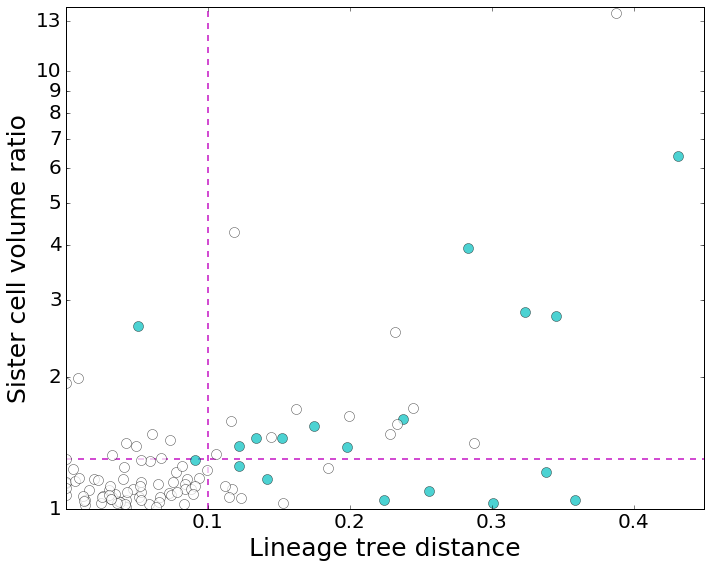

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.plot([.1, .1], [1, 100], 'm--', lw = 2, alpha = .7)
ax.plot([0, 100], [1.3, 1.3], 'm--', lw = 2, alpha = .7)
for c1, c2 in couples:
    mean_nv=np.mean([new_sim_nv[c1], new_sim_nv[c2]])
    ratio1=get_max_vol(c1, new_vol, new_lin_tree)/get_min_vol(c1, new_vol, new_lin_tree)
    ratio2=get_max_vol(c2, new_vol, new_lin_tree)/get_min_vol(c2, new_vol, new_lin_tree)
    mean_ratio=np.mean([ratio1, ratio2])
    

    if short_name(new_names[c1]) in cells_with_spec:
        ax.plot(mean_nv, mean_ratio, 'co', ms = 10, alpha = .7)
    else:
        ax.plot(mean_nv, mean_ratio, 'wo', ms = 10, alpha = .7)

ax.tick_params(axis='x', which='both', labelsize=20)
ax.set_xticks(np.arange(.1, .45, .1))
ax.set_xlim((0, .45))
ax.set_ylim((1, 14))
ax.semilogy()
ax.set_yticks(range(1, 11) + [13])
ax.set_yticklabels(range(1, 11) + [13])
ax.tick_params(axis='y', which='both', labelsize=20)
ax.set_xlabel('Lineage tree distance', fontsize=25)
ax.set_ylabel('Sister cell volume ratio', fontsize=25)
fig.tight_layout()
plt.savefig(p_to_figures + 'dist_vs_vol_ratio.pdf')